In [78]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import math
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import time
from sklearn.metrics.pairwise import rbf_kernel
%matplotlib inline

def createK(data, c):
    return rbf_kernel(data, data, gamma=1/c)

def calcBetaK(alphaK, kernelFunction, data, x, c):
    kernel = rbf_kernel(data, x.reshape(1, -1), 1/c)
    return np.dot(alphaK, kernel)

def centerK(K):
    ''' Returns centered K matrix, see K. Murphy 14.43 '''
    l = len(K)
    l_ones = np.ones((l, l), dtype=int) / l
    Kcentered = K - np.dot(l_ones,K)-np.dot(K,l_ones)+np.dot(l_ones,np.dot(K,l_ones))
    return Kcentered

def normAlpha(alpha, lambdas):
    ''' Returns new alpha corresponding to normalized eigen vectors,
        so that lambda_k(a^k * a^k) = 1 '''
    for i,a in enumerate(alpha):
        a /= np.sqrt(lambdas[i])
    return alpha

def calcZ(alpha, data, x, kernelFunction, c, z0, maxIters, showProgress=False):
    ''' Equation (10), returns pre-image z for single input datapoint x '''
    z = z0
    cov_0 = np.std(data, axis=0)**2*np.identity(z0.size)
    m = np.mean(data, axis=0)
    iters=0
    beta = [calcBetaK(aK, kernelFunction, data, x, c) for aK in alpha]
    gamma = [calcGammaIOpt(alpha, i, beta) for i in range(len(data))]
    
    while iters < maxIters:
        numerator, denom = 0, 0
        kernel = rbf_kernel(data, z.reshape(1, -1), 1/c)
        for i, xi in enumerate(data):
            gammaI = gamma[i] * kernel[i][0]
            numerator += gammaI * xi
            denom += gammaI
        if denom!=0: #handling numerical instability
            z = numerator/denom
            if showProgress:
                print(iters, z)
            iters +=1
        else:
            # print("instability", "z", z, "x", x, "numerator", numerator)
            iters =0
            z = z0 + np.random.multivariate_normal(np.zeros(z0.size), cov_0)
            numerator, denom = 0, 0
    return z

def calcGammaIOpt(alpha, i, beta):
    ''' returns gamma_i = sum_{k=1}^n beta_k * alpha_i^k '''
    gammaI = 0
    alphaI = alpha.T[i]
    for k, alphaKI in enumerate(alphaI):
        gammaI += beta[k] * alphaKI
    return gammaI

def myPCA(data, test, n):
    l, d = data.shape
    C = np.zeros((d, d))
    m = np.mean(data, axis=0)
    for xi in data-m:
        C += 1/l*np.dot(xi.reshape((d, 1)), xi.reshape((d, 1)).T)
    lambdas, v = np.linalg.eigh(C)
    Z = np.zeros(test.shape) # result
    for i, xi in enumerate(test-m):
        Z[i] = m+np.sum(np.array([np.dot(np.dot(xi, vi), vi) for vi in v[-n:]]), axis=0)
    return Z

def myKPCA(data, test, n, c, maxIters, showProgress=False, debug=False):
    l = len(data)
    K = centerK(createKNew(data, c))
    lambdas, alphas = np.linalg.eigh(K)
    alphas = alphas.T
    lambdas = lambdas/l
    lambdas, alphas = lambdas[-n:], alphas[-n:]
    alphas = normAlpha(alphas, lambdas)
    Z = np.zeros(test.shape)
    for i, xi in enumerate(test):
        Z[i] = calcZ(alphas, data, xi, gaussianKernel, c, xi, maxIters, showProgress=showProgress)
    return Z

# I The framework

"In the report you should first describe the article on such a level of detail that your peer students in this course understand the method, and so that it is clear to the reader that you understand the method too."

Linear PCA consists in a orthogonal basis transformation that can be used for dimensionality reduction. In the context of de-noising it is very limited: indeed it can only de-noise linear patterns as we shall show in the experiments. Kernel PCA solves this limitation. It makes use of a function $\Phi$ that maps that data from the input space (typically $\mathbb{R}^N$) to a feature space. The feature space is typically of much higher dimension than the input space, for the gaussian kernel on which we will focus the feature space is of infinite dimension. Linear PCA is performed in the feature space. The transformation is linear in the feature space but non-linear in the input space.Data in the feature space is projected onto the main principal components. The difficult part is to take these projections back to the input, this is called the pre-image problem and it is the major contribution of this paper to propose an algorithm to solve this problem.
In the original paper the authors have used this method in the purpose of de-noising.

Let $x$ be a test point. $\{x_i\}$_{i=1}^l are the "train" data. $\{V^k\}$ are the eigeinvectors of the covariance matrix $\bar{\mathbf{C}}$. If we suppose the $\Phi$-images of the train data to be centered (in the feature space), the covariance matrix is $\bar{\mathbf{C}}=\frac{1}{l}\sum_{k=1}^l\Phi(x_k)\Phi(x_k)^T$, so an eigenvector $V$ with eigenvalue $\lambda$ satisfies 
$\bar{\mathbf{C}}V=\lambda V$, 
i.e $\frac{1}{l}\sum_{k=1}^l(\Phi(x_k)\Phi(x_k)^T)V=\lambda V$, 
i.e $\frac{1}{l}\sum_{k=1}^l\underbrace{(\Phi(x_k)\cdot V)}_{scalar}\Phi(x_k)=\lambda V$
For non-zero eigenvalue $\lambda$ we have:
$V=\frac{1}{l\lambda}\sum_{k=1}^l\underbrace{(\Phi(x_k)\cdot V)}_{scalar}\Phi(x_k)$
So $V$ is a linear combination of the $\Phi$-images of the training data, there exist coefficients $\{\alpha_i\}_{i=1}^l$ such that $V=\sum_{i=1}^l\alpha_i \Phi(x_i)$. Now let's see how to actually compute these coefficients $\alpha_i$. The equation $\lambda V=\bar{\mathbf{C}}V$ can be written in $l$ scalar equations 
$$\forall j \in \{1,\dots,l\} \lambda(V \cdot \Phi(x_j))=(\bar{\mathbf{C}}V\cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\Big[\frac{1}{l}\sum_{k=1}^l(\Phi(x_k) \Phi(x_k)^T)\sum_{i=1}^l\alpha_i\Phi(x_i)\Big] \cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\Big[\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_i\underbrace{(\Phi(x_k) \Phi(x_k)^T)\Phi(x_i)}_{(\Phi(x_k)\cdot \Phi(x_i))\Phi(x_k)}\Big] \cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_i(\Phi(x_k)\cdot \Phi(x_i))\Phi(x_k) \cdot \Phi(x_j))$$
$$\lambda \sum_{i=1}^l\alpha_ik(x_i, x_j)=(\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_ik(x_i, x_k)\Phi(x_k) \cdot \Phi(x_j))$$
$$\lambda \sum_{i=1}^l\alpha_ik(x_i, x_j)=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_ik(x_i, x_k)k(x_k, x_j)$$
$$\lambda \sum_{i=1}^l\alpha_iK_{ij}=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_iK_{ik}K_{kj}$$
$$\lambda \sum_{i=1}^l\alpha_i\underbrace{K_{ij}}_{=K_{ji} \text{because K symmetric}}=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_iK_{ik}K_{kj}$$
$$\lambda (K\alpha)_j = \frac{1}{l}\sum_{k=1}^l(K\alpha)_kK_{kj}$$
$$\lambda (K\alpha)_j = \frac{1}{l}(KK\alpha)_j$$
So in a vector form we have:
$$\lambda K\alpha = \frac{1}{l}K^2\alpha$$
$$l \lambda K \alpha = K^2 \alpha$$
$$l \lambda \alpha = K \alpha$$
So
* The eigenvectors $V^k$ (with associated eigenvalues $\lambda^k$) can be written as $V^k=\sum_{i=1}^l\alpha_i^k\Phi(x_i)$ and the vector $\alpha^k=(\alpha_1^k, \dots, \alpha_l^k)^T$ is an eigenvector of the kernel matrix $K$ with eigenvalue $l \lambda^k$
* Projections of the test point $x$ on the $V^k$: $\beta_k=\sum_{i=1}^l\alpha_i^kk(x,x_i)$, only depends on the test point $x$ and the training data $\{x_i\}_{i=1}^l$, does not depend on the sequence $z_0, \dots, z_t, \dots$
* Let $n$ be the number of principal components and $P_n$ the operator that project the $\Phi$-image of the test point $\Phi(x)$ onto the span of the eigenvectors $\{V^k\}_{k=1}^n$, 
$P_n(\Phi(x))=\sum_{k=1}^n(\Phi(x)\cdot V^k)V^k
             =\sum_{k=1}^n\beta_k V^k$
* Pre-image problem: the main difficulty is to find the pre-image of this projected vector $P_n(\Phi(x))$, that is to say find the vector $z$ in the input space such that $\Phi(z)=P_n(\Phi(x))$. We do not know anything about the mapping $\Phi$ from the input space to the feature space, it is probably not injective and as a consequence there may not exist such a vector $z$ in the input space such that its $\Phi$-image is the projected vector $P_n(\Phi(x))$. So we have to find an approximation of the pre-image of $P_n(\Phi(x))$ so a vector $z$ such that the quantity
$\rho(z)=||\Phi(z) - P_n(\Phi(x))||^2$ is minimal. If the kernel is gaussian, that is to say in the form $k(x,y)=\exp(-||x-y||^2/c)$ (with $c\neq 0$) we can find an iterative scheme to minimize $\rho(z)$
* Let's expand the square in $\rho(z)$:
$$\rho(z) = ||\Phi(z)||^2 - 2(\Phi(z) \cdot P_n(\Phi(x))) + ||P_n(\Phi(x)||^2$$
$$\rho(z) = k(z, z) - 2\Phi(z) \cdot \sum_{k=1}^n\beta_k \sum_{i=1}^l\alpha_i^k\Phi(x_i) + \underbrace{||P_n(\Phi(x)||^2}_{\text{does not depend on }z}$$
$$\rho(z) = \underbrace{k(z, z)}_{constant} - 2\sum_{k=1}^n\beta_k \sum_{i=1}^l\alpha_i^k\Phi(z) \cdot \Phi(x_i) + \underbrace{||P_n(\Phi(x)||^2}_{\text{does not depend on }z}$$
$$\rho(z) = \underbrace{k(z, z)}_{constant} - 2\sum_{i=1}^l\sum_{k=1}^n\beta_k \alpha_i^k k(z,x_i) + \underbrace{||P_n(\Phi(x)||^2}_{\text{does not depend on }z}$$
Let's denote $\forall i \in \{1, \dots, l\}, \gamma_i=\sum_{k=1}^n\beta_k \alpha_i^k$ and $\Omega$ the terms that are constant with respect to $z$, that is $\Omega=k(z,z) + ||P_n(\Phi(x))||^2$, we have
$$\rho(z) = -2\sum_{i=1}^l\gamma_i k(z,x_i) + \Omega$$
Finally let's define $\rho^{\prime}(z) = \sum_{i=1}^l\gamma_i k(z,x_i)$. Minimizing $\rho(z)$ is the same as maximizing $\rho^{\prime}(z)$. Let $z^*$ be the maximum of $\rho^{\prime}(z)$, a necessary condition is the derivate of $\nabla_z(\rho^{\prime}(z^*))=0$. Let's compute this derivative:
$$\rho^{\prime}(z) = \sum_{i=1}^l\gamma_i k(z,x_i)$$
$$\nabla_z(\rho^{\prime})(z) = \sum_{i=1}^l\gamma_i \frac{\partial ||z-x_i||^2}{\partial z}k^{\prime}(||z-x_i||^2)$$
We have 
$$\frac{\partial ||z-x_i||^2}{\partial z} = 2(z-x_i)$$
and $k^{\prime}(||z-x_i||^2)$ denotes the derivate of the real function $f(y)=e^{-y/c}$ taken at $y=||z-x_i||^2$ so $k^{\prime}(||z-x_i||^2)=-\frac{1}{c}\exp(-\frac{||z-x_i||^2}{c})=-\frac{1}{c}k(z, x_i)$ and we have:
$$\nabla_z(\rho^{\prime}(z))=-\frac{2}{c}\sum_{i=1}^l\gamma_i(z-x_i)k(z,x_i)$$
Setting the derivative to zero we obtain:
$$\sum_{i=1}^l\gamma_i(z^*-x_i)k(z^*,x_i)=0$$
$$z^*=\frac{\sum_{i=1}^l\gamma_i x_i k(z^*,x_i)}{\sum_{i=1}^l\gamma_i k(z^*,x_i)}$$
* Iteration scheme: 
$$z_{t+1}=\frac{\sum_{i=1}^l\gamma_i x_i \exp(-\frac{||z_t-x_i||^2}{c})}{\sum_{i=1}^l\gamma_i exp(-\frac{||z_t-x_i||^2}{c})}$$
We can start with the test point: $z_0 = x$
* $\gamma_i = \sum_{k=1}^n\beta^k \alpha_i^k$, depends on the projections of the test point $x$ on the eigenvectors $V^k$ of the covariance matrix $\bar{\mathbf{C}}$ of the training data samples $\{x_i\}_{i=1}^l$ and on the coordinates of these eigenvectors $V^k$ in the span of the $\Phi$-images of the training data samples $\{\Phi(x_i)\}_{i=1}^l$, does not depend on the sequence $z_0, \dots, z_t, \dots$

The conclusion is that $z^*$ is a fixed point of the function $f(z)=\frac{\sum_{i=1}^l\gamma_i x_i k(z,x_i)}{\sum_{i=1}^l\gamma_i k(z,x_i)}$, this expression is valid assuming that the denominator which is equal to $\sum_{i=1}^l\gamma_i k(z,x_i)=\Phi(z)\cdot P_n(\Phi(x))$ is non-zero. Because the kernel $k$ is a continuous function, assuming that $P_n(\Phi(x))\neq 0$ there is a neighborhood of the extremum of $\rho^{\prime}$ where the function $f$ is defined. Should we start with a good guess $z_0$, the following iteration scheme will converge to the fixed point of $f$ that corresponds to the extremum of $\rho^{\prime}$:
\begin{align}
z_{t+1}=\frac{\sum_{i=1}^l\gamma_i x_i k(z_t,x_i)}{\sum_{i=1}^l\gamma_i k(z_t,x_i)}
\end{align}

## II Eleven gaussians in $\mathbb{R}^{2}$
Dataset:
* data set from eleven Gaussians in $\mathbb{R}^{2}$ with variance $\sigma^2$ in each component
* centers of the Gaussians randomly chosen in $[-1, 1]^2$
* selecting from each source $100$ points as a training set and $33$ points for a test set
* different data sets with different values of $\sigma$, $\sigma= 0.05, 0.1, 0.2, 0.4, 0.8$

## 1) Generate the data in $\mathbb{R}^2$

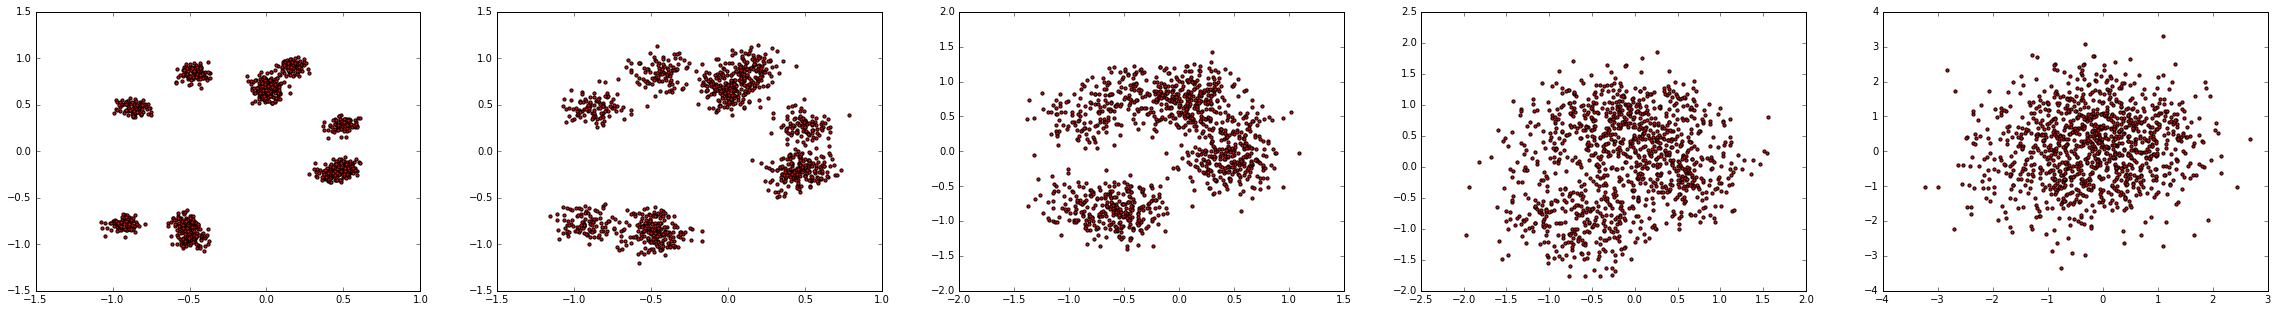

In [109]:
sigmas = np.array([0.05, 0.1, 0.2, 0.4, 0.8])
centers = np.random.uniform(-1, 1, size=(11, 2))

nTrain, nTest = 100, 33
Xtrain, Xtest = [], []
for s in sigmas:
    xtrain, xtest = [], []
    for center in centers:
        for _ in range(nTrain):
            xtrain.append(np.random.multivariate_normal(center, s**2*np.identity(2)))
        for _ in range(nTest):
            xtest.append(np.random.multivariate_normal(center, s**2*np.identity(2)))
    Xtrain.append(xtrain)
    Xtest.append(xtest)
Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
plt.figure(figsize=(8*5, 5))
for sigmaIdx in range(5):
    plt.subplot(1, 5, sigmaIdx+1)
    plt.scatter(Xtrain[sigmaIdx][:, 0], Xtrain[sigmaIdx][:, 1], c="r", s=10)
#plt.title("Training data\n $\sigma=$" + str(sigmas[sigmaIdx]) + "\n" + str(nTrain) + " samples per Gaussian")

## 2) Linear PCA

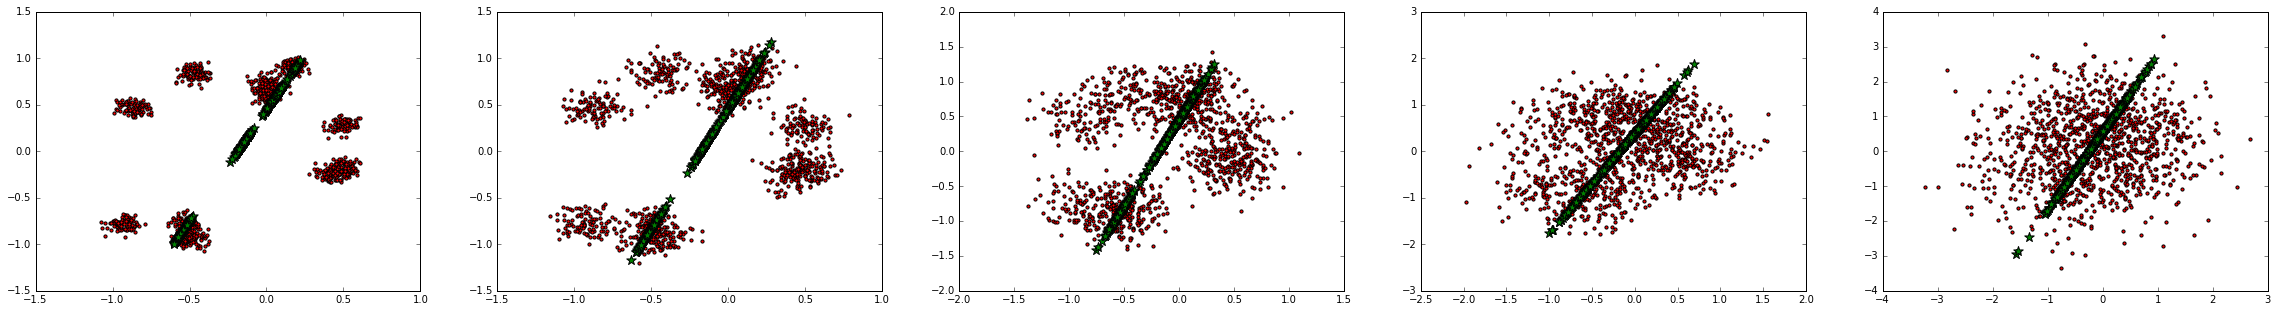

In [112]:
plt.figure(figsize=(8*5, 5))
Zpca = np.zeros((5, nTest*11, 2))
for sigmaIdx in range(5):
    plt.subplot(1, 5, sigmaIdx+1)
    Zpca[sigmaIdx] = myPCA(Xtrain[sigmaIdx], Xtest[sigmaIdx], 1)
    plt.scatter(Xtrain[sigmaIdx][:, 0], Xtrain[sigmaIdx][:, 1], c="r", s=10, label="train data")
    plt.scatter(Zpca[sigmaIdx][:, 0], Zpca[sigmaIdx][:, 1], c="g", marker="*", s=100, label="denoised")
#plt.title("test samples de-noised with PCA\n"+"number of principal components=" + str(n))

## 3) Kernel PCA

0
1
2
3
4


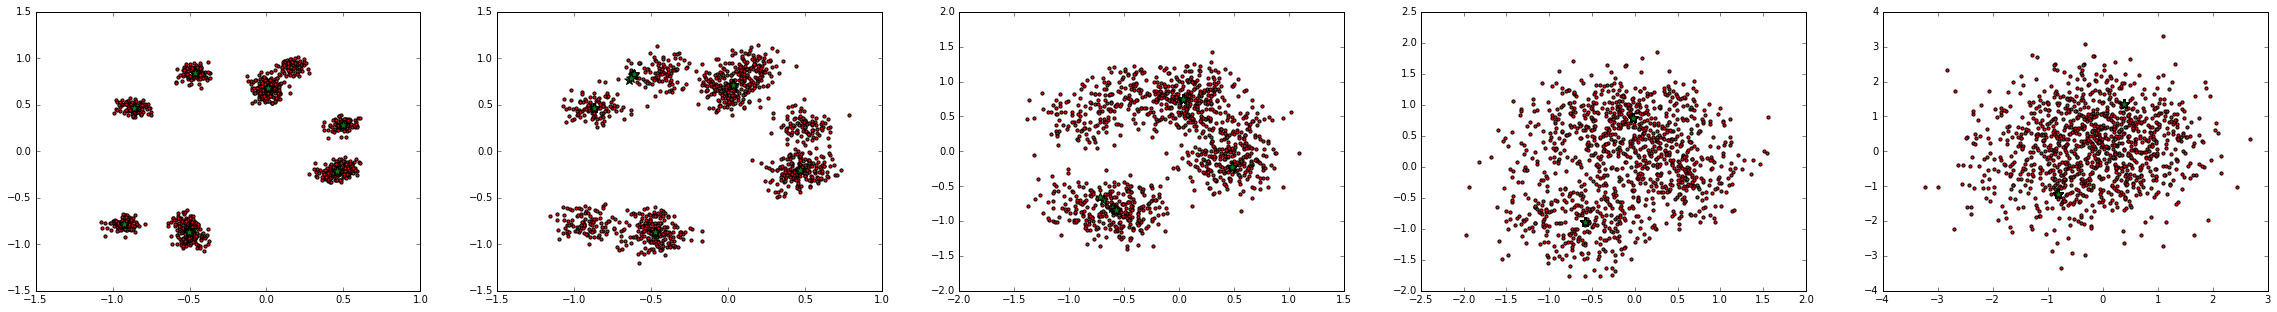

In [111]:
maxIters = 10

plt.figure(figsize=(8*5, 5))
Zkpca = np.zeros((5, nTest*11, 2))
for sigmaIdx in range(5):
    print(sigmaIdx)
    plt.subplot(1, 5, sigmaIdx+1)
    c = 2*2*sigmas[sigmaIdx]**2
    Zkpca[sigmaIdx] = myKPCA(Xtrain[sigmaIdx], Xtest[sigmaIdx], 1, c, maxIters)
    plt.scatter(Xtrain[sigmaIdx][:, 0], Xtrain[sigmaIdx][:, 1], c="r", s=10, label="train data")
    plt.scatter(Zkpca[sigmaIdx][:, 0], Zkpca[sigmaIdx][:, 1], c="g", marker="*", s=100, label="denoised")
#plt.title("test samples de-noised with Kernel PCA\n" + "number of principal components=" + str(n))

## 4) Plots

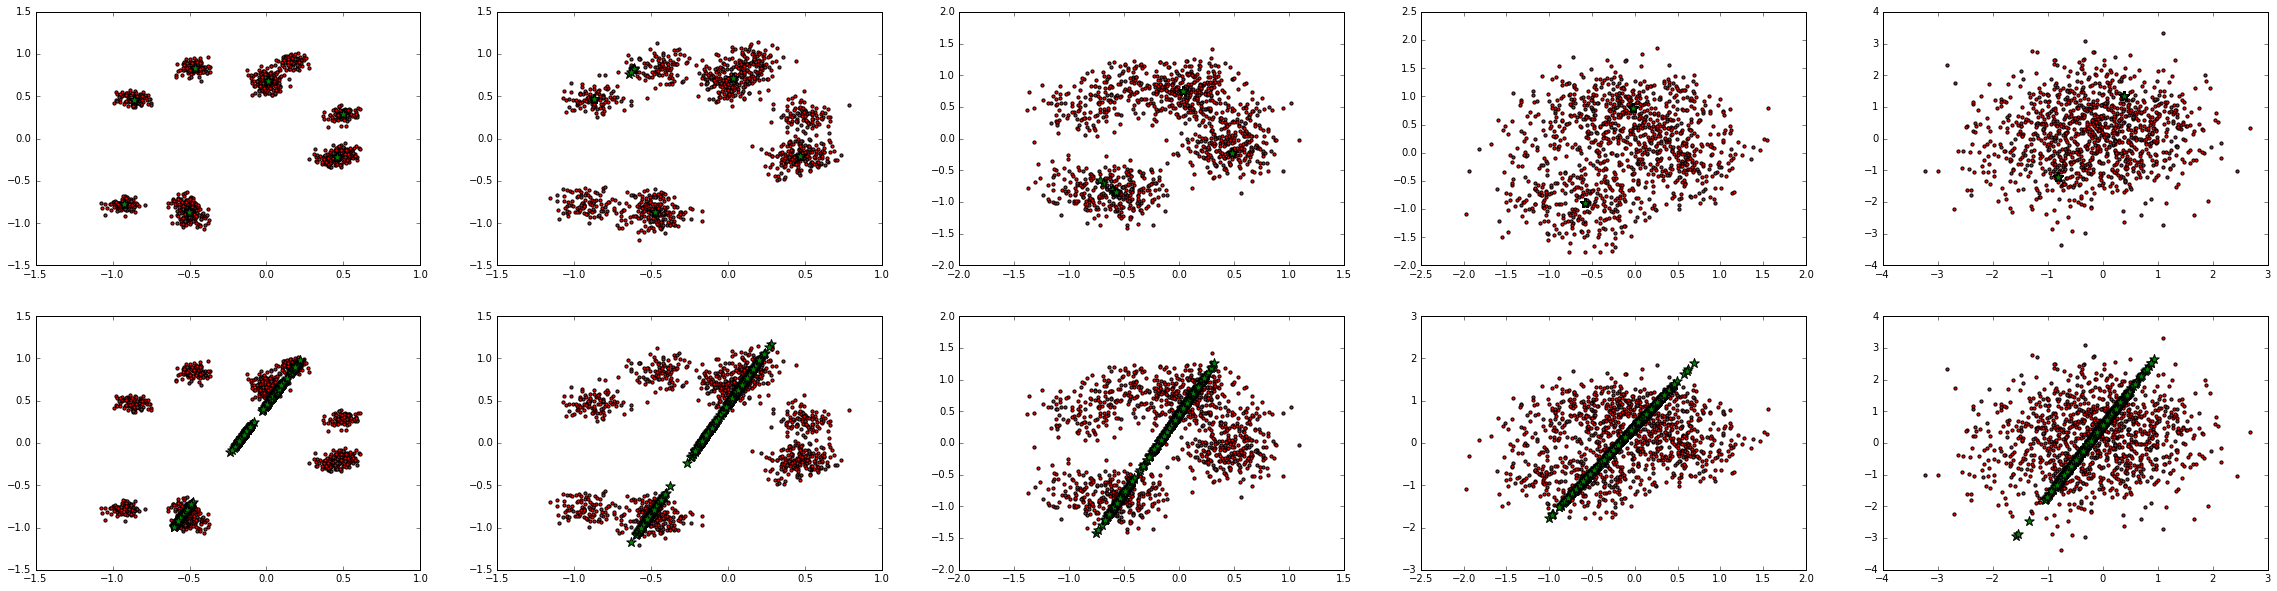

In [113]:
plt.figure(figsize=(8*5, 10))
for sigmaIdx in range(5):
    plt.subplot(2, 5, sigmaIdx+1)
    plt.scatter(Xtrain[sigmaIdx][:, 0], Xtrain[sigmaIdx][:, 1], c="r", s=10, label="train data")
    plt.scatter(Zkpca[sigmaIdx][:, 0], Zkpca[sigmaIdx][:, 1], c="g", marker="*", s=100, label="denoised")
    plt.subplot(2, 5, 5+sigmaIdx+1)
    plt.scatter(Xtrain[sigmaIdx][:, 0], Xtrain[sigmaIdx][:, 1], c="r", s=10, label="train data")
    plt.scatter(Zpca[sigmaIdx][:, 0], Zpca[sigmaIdx][:, 1], c="g", marker="*", s=100, label="denoised")

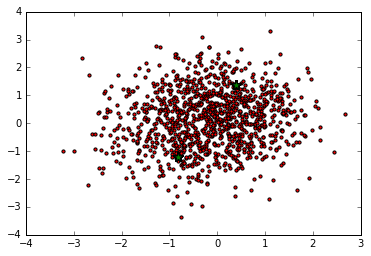

In [144]:
sigmaIdx = 4
error = 0
for z in Zkpca[sigmaIdx]:
    error += np.linalg.norm(z-centers[int(i/nTest)])**2
error /= nTest*11
    
plt.scatter(Xtrain[sigmaIdx][:, 0], Xtrain[sigmaIdx][:, 1], c="r", s=10, label="train data")
plt.scatter(Zkpca[sigmaIdx][:, 0], Zkpca[sigmaIdx][:, 1], c="g", marker="*", s=100, label="denoised")
#plt.title("test samples denoised (green) with kernel PCA" + 
          #"\n n=1"
          #"\n $\sigma=$" + str(sigmas[sigmaIdx]))

## 4) Kernel PCA with more components in reconstruction

20


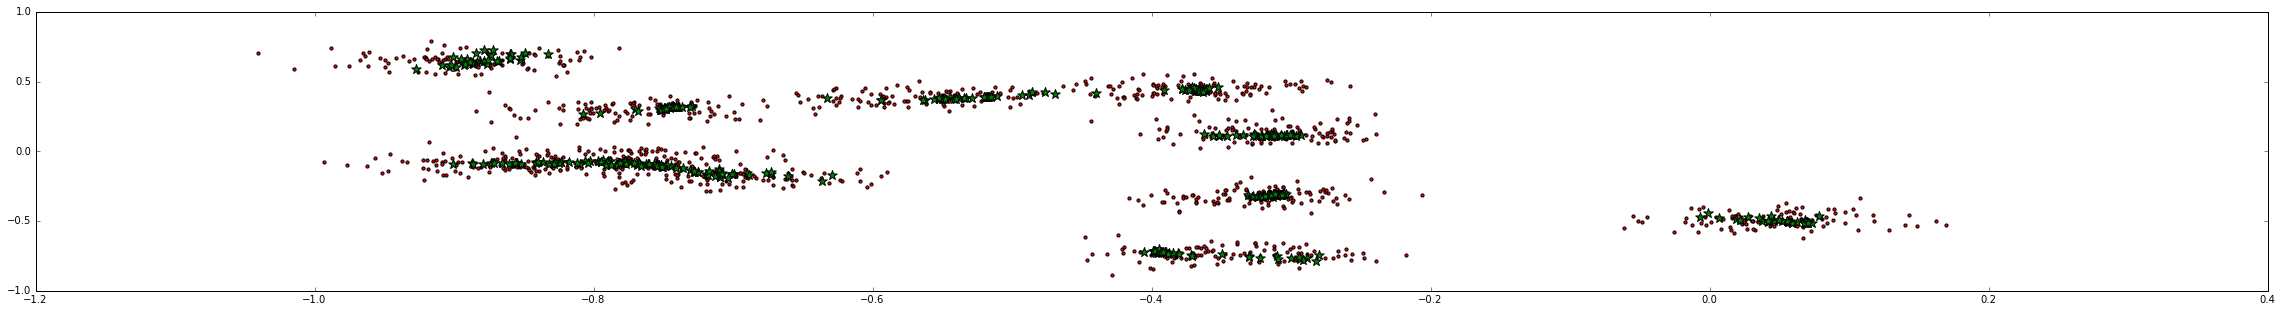

In [99]:
importlib.reload(framework)
from framework import *
maxIters = 30
sigmaIdx = 0

plt.figure(figsize=(8*5, 5))
for n in [20]:
    print(n)
    c = 2*2*sigmas[sigmaIdx]**2
    Zkpca = myKPCA(Xtrain[sigmaIdx], Xtest[sigmaIdx], n, c, maxIters)
    plt.scatter(Xtrain[sigmaIdx][:, 0], Xtrain[sigmaIdx][:, 1], c="r", s=10, label="train data")
    plt.scatter(Zkpca[:, 0], Zkpca[:, 1], c="g", marker="*", s=100, label="denoised")
#plt.title("test samples de-noised with Kernel PCA\n" + "number of principal components=" + str(n))

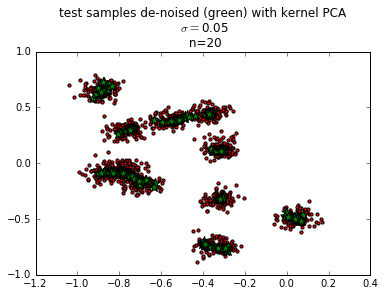

In [107]:
plt.scatter(Xtrain[0][:, 0], Xtrain[0][:, 1], c="r", s=10, label="train data")
plt.scatter(Zkpca[:, 0], Zkpca[:, 1], c="g", marker="*", s=100, label="denoised")
plt.title("test samples de-noised (green) with kernel PCA" +
          "\n $\sigma=$" + str(sigmas[sigmaIdx]) +
          "\n n=" + str(n))

# III Pre-images from initialisation to convergence

## 1) Generate some 2D data

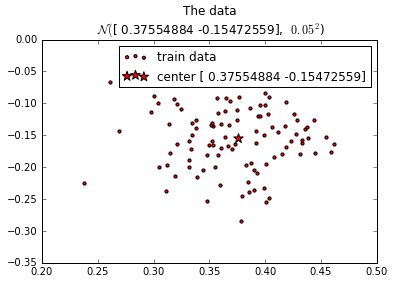

In [145]:
sigma = float(0.05)
center = np.random.uniform(-1, 1, size=2)
Xtrain = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=100)
Xtest = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=33)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10, label="train data")
plt.scatter(center[0], center[1], c="r", s=100, marker="*", label="center " + str(center))
plt.title("The data\n $\mathcal{N}($" + str(center) +  ",  $0.05^2$)")
plt.legend()

Let's see how the sequence $z_t$ evolves. And also check if convergence is reached at the same point across different random starting points.

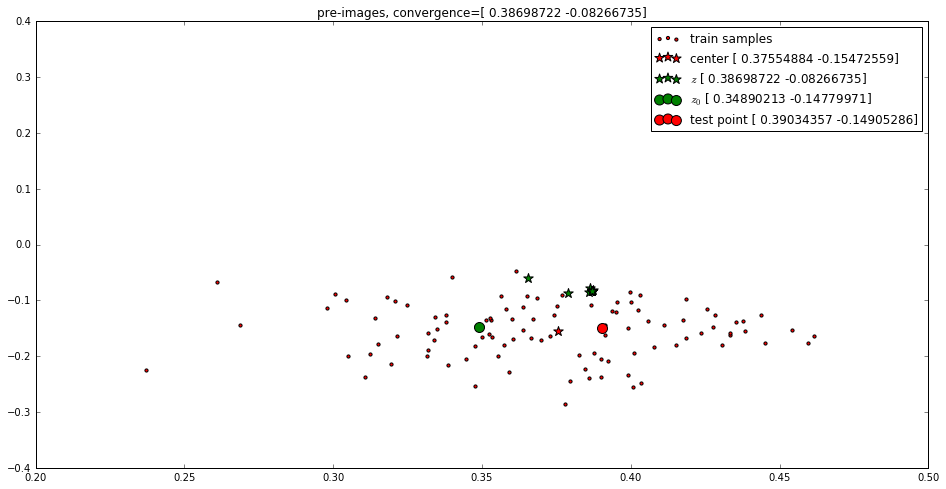

In [148]:
plt.figure(figsize=(16, 8))
n = 1 # n components for reconstruction
iters=0
maxIters = 300 # number of iterations
c = 2*2*sigma**2
l = len(Xtrain)
x = Xtest[0]
z = [list(np.random.multivariate_normal(center, sigma**2*np.identity(2)))] # random starting point
z0 = z[0] # in case of numerical instability
K = centerK(createKNew(Xtrain, c))
lambdas, alphas = np.linalg.eigh(K) 
alphas = alphas.T
lambdas = lambdas/l 
lambdas, alphas = lambdas[-n:], alphas[-n:]
alphas = normAlpha(alphas, lambdas)

beta = [calcBetaK(aK, gaussianKernel, Xtrain, x, c) for aK in alphas]
gamma = [calcGammaIOpt(alphas, i, beta) for i in range(len(Xtrain))]

while iters < maxIters:
    numerator, denom = 0, 0
    kernel = rbf_kernel(Xtrain, np.array(z[-1]).reshape(1, -1), 1/c)
    for i, xi in enumerate(Xtrain):
        gammaI = gamma[i] * kernel[i][0]
        numerator += gammaI * xi
        denom += gammaI
    if denom!=0: #handling numerical instability
        z.append(numerator/denom)
        iters +=1
    else:
        print("---", "instability", denom, "---")
        iters = 0
        z = list(z0 + np.random.multivariate_normal(np.zeros(2), sigma**2*np.identity(2)))
        numerator, denom = 0, 0
        
z = np.array(z)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10, label="train samples")
plt.scatter(center[0], center[1], c="r", s=100, marker="*", label="center " + str(center))
plt.scatter(z[0:, 0], z[0:, 1], c="g", s=100, marker="*", label="$z$ " + str(z[-1]))
plt.scatter(z[0, 0], z[0, 1], c="g", marker="o", s=100, label="$z_0$ " + str(z[0]))
plt.scatter(x[0], x[1], c="r", s=100, label="test point " + str(x))
plt.title("pre-images, convergence=" + str(z[-1]))
plt.legend()

# IV Discussion

It's been twenty years that this paper has been published and it seems it was the first to propose an algorithm to solve the pre-image problem. Since then several papers (for example [2] and [3]) proposed other solutions that have proven to avoid the drawbacks of the iteration scheme of this paper. Indeed, as stresses by the authors it suffers from numerical instabilities. It is a pity that they did not mention these difficulties during the experiment. We do not know if they faced it and if so how they tackle them in practise. Choosing another random starting guess is not so easy. Indeed the authors did not stress much the fact that the iteration scheme could converge to a local extremum of the objective function $\rho$. The convergence is sensitive to the initial guess so the choice of the random starting point after numerical instability occurs matters a lot.